# King County Home Sale Data: Analysis and Modeling
Flatiron School Data Science: Project 2
- **Author**: Zaid Shoorbajee
- **Instructor**: Matt Carr
- **Pace**: Flex, 20 weeks

## Overview and Business Undestanding

This project analyzes data about homes sold in King County, Washington between May 2014 and May 2015, in order to make recommendations to a real estate agency. The agency wants to advise its clients on how to increase the estimated sale price of their homes. The anlysis will allow the agency to advise clients on 1) what kinds of renovations to make and 2) which aspects of their home to emphasize in a listing.

These are decisions that home sellers can make in an attempt to increase their sale price. Especially with renovations, this information will be useful because it will give sellers a sense of what kinds of renovations will result in a higher expected sale price.

## Data Understanding

The data I have available to me contains information about homes sold in King County between May 2014 and May 2015. The original dataset contains records of 21,597 home sales. It includes:
* How much the house sold for
* Square footage of the house and the lot
* Number of floors, bedrooms, and bathrooms
* The quality of the view from the house
* Whether the house is on a waterfront
* The house's grade (relates to construction materials and quality)
* The house's condition (relates to age and maintenance)
* The year the house was built
* The year the house was renovated
* The location of the house
* The square footage of the house and lot of the nearest 15 neighbors

I use the sale price as the target variable, as it's the value we want to predict on behalf of the real estate agency and its clients.

Ultimately, I drop several of these features before constucting models because they may not be useful to a homeowner or they aren't for someone selling their home to change. For example, if your house is not in a specific ZIP Code, you can't change that before you sell it.

The predictor that is most correlated with price is `sqft_living`, or the square footage of the living area of the house. I use this feature alone in the baseline model, then add more features to try to improve the fit of the model. 

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import statsmodels.api as sm

## Data Preparation 

The used in this notebook has **already been cleaned and processed** for linear regression modeling in a **separate notebook**.

Below is a summary of how I prepared the data. You can also view the process in detail in the notebook titled `data_preparation.ipynb` in this repository.

#### Summary of data preparation:

* Null values in `waterfront` and `view` were replaced with 'NO' and 'None', respectively.
* `view` was changed into a binary variable, rather than rating the quality of the view
* `yr_renovated` was changed into a a binary variable called `renovated_last_10`, indicating whether the house was renovated in the 10 years prior to sale
* I could not infer what null values in `sqft_basement` indicated, so `sqft_basement` and `sqft_above` were dropped.
* `yr_built` was converted to `age`
* The following variables were dropped because they either can't be changed by someone selling their home or don't provide much useful information.
    * `id`
    * `date`
    * `zipcode`
    * `lat`
    * `long`
    * `sqft_living15`
    * `sqft_lot15`
* The following are treated as categorical variables.
    * `bedrooms`
    * `bathrooms`
    * `floors`
    * `waterfront`
    * `view`
    * `condition`
    * `grade`
    * `renovated_last_10`
* If a category appeared in the dataset fewer than 40 times, I dropped that category from the dataset.
    * For example, there are 2 houses with 8 bathrooms lists, and there is a single house with supposedly 33 bedrooms. Theses types of categories are likely to generate noise, so I drop them.
* I derived dummy variables from the categorical variables above.
    * Rather than letting Pandas arbitrarily drop the first dummy it sees, I chose specific dummies to drop (lowest number of bedrooms, the lowest grade, etc.), in order to make the model cefficients more intuitive to read.


In [2]:
# Loading and previewing the dataset

data = pd.read_csv('./data/data_post_prep.csv', index_col='Unnamed: 0')
data.head()

,price,sqft_living,sqft_lot,age,waterfront,view,renovated_last_10,floors_1.5,floors_2.0,floors_2.5,...,condition_3_Average,condition_4_Good,condition_5_Very_Good,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,grade_10_Very_Good,grade_11_Excellent,grade_12_Luxury
0,221900.0,1180,5650,59,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,538000.0,2570,7242,63,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,180000.0,770,10000,82,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,604000.0,1960,5000,49,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,510000.0,1680,8080,28,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21378 entries, 0 to 21596
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21378 non-null  float64
 1   sqft_living            21378 non-null  int64  
 2   sqft_lot               21378 non-null  int64  
 3   age                    21378 non-null  int64  
 4   waterfront             21378 non-null  int64  
 5   view                   21378 non-null  int64  
 6   renovated_last_10      21378 non-null  int64  
 7   floors_1.5             21378 non-null  int64  
 8   floors_2.0             21378 non-null  int64  
 9   floors_2.5             21378 non-null  int64  
 10  floors_3.0             21378 non-null  int64  
 11  bedrooms_2             21378 non-null  int64  
 12  bedrooms_3             21378 non-null  int64  
 13  bedrooms_4             21378 non-null  int64  
 14  bedrooms_5             21378 non-null  int64  
 15  be

In [4]:
### GROUP DUMMIES TOGETHER INTO LISTS
# Doing this for conveniece

dummies = ['floors', 'bedrooms', 'bathrooms', 'condition', 'grade']
floors_dummies = []
bedrooms_dummies = []
bathrooms_dummies = []
condition_dummies = []
grade_dummies = []

for col in list(data.columns):
    for cat in dummies:
        if col.startswith(cat):
            eval(cat + '_dummies').append(col)

# Now if I want to add a whole category into the model, I can simply
# plug in the corresponding list 

### GROUP BINARY COLUMNS INTO ONE LIST
binary_cols = ['waterfront', 'view', 'renovated_last_10']

### GROUP CONTINUOUS COLUMNS INTO ONE LIST

num_cols = ['price', 'sqft_living', 'sqft_lot', 'age']

## Checking for linear relationships with `price` and collinearity of predictors

In [5]:
# Isolate continuous variables

data_num = data[num_cols]

In [6]:
data_num.head()

,price,sqft_living,sqft_lot,age
0,221900.0,1180,5650,59
1,538000.0,2570,7242,63
2,180000.0,770,10000,82
3,604000.0,1960,5000,49
4,510000.0,1680,8080,28


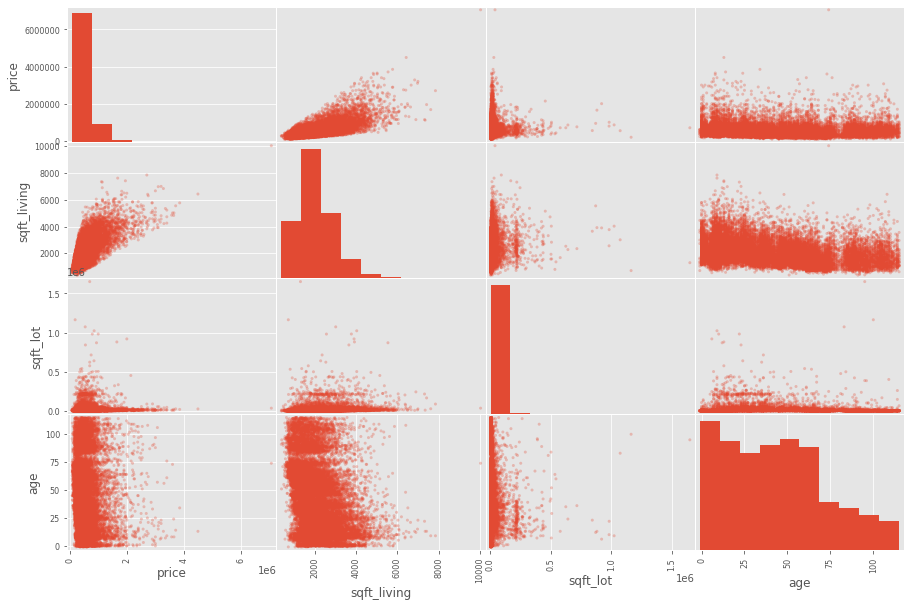

In [7]:
pd.plotting.scatter_matrix(data_num, figsize=(15,10), alpha=.3);

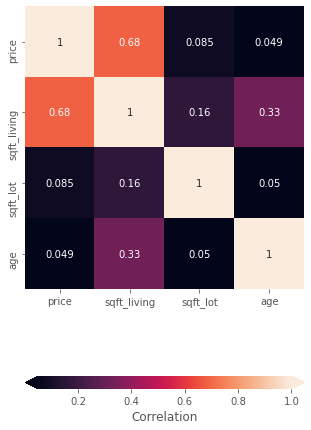

In [8]:
fig, ax = plt.subplots(figsize = (5,8))

sns.heatmap(
    data_num.corr().abs(),
#     mask=np.triu(np.ones_like(data.corr(), dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

#### Observations

* I see that `sqft_living` is the only continuous variable that has a linear relationship with `price`, although the plot has a conical shape.
* I may also benefit from log-transforming `sqft_living` and the target, `price`.

**Which variables have high collinearity?**

In [9]:
# Checking for collinarity of all combinations of predictors

data_pred = data_num.drop('price', axis=1)

pred_corr = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
pred_corr['pairs'] = list(zip(pred_corr.level_0, pred_corr.level_1))
pred_corr.rename(columns={0: 'Coefficient'}, inplace=True)
pred_corr.set_index('pairs', inplace=True)
pred_corr.drop(columns=['level_1', 'level_0'], inplace = True)
pred_corr.drop_duplicates(inplace=True)
pred_corr

,Coefficient
pairs,
"(sqft_living, sqft_living)",1.000000
"(sqft_living, age)",0.326558
"(sqft_living, sqft_lot)",0.164552
"(sqft_lot, age)",0.049919


**There doesn't appear to be any notable collinarity among the continuous variables.**

**I am still going to drop all of them except `sqft_living` because it's the only one with a linear relationship with `price`.**

In [10]:
# Making sqft_living the only continuous predictor

data.drop(['sqft_lot', 'age'], axis=1, inplace = True)

## Modeling

The following function:
* fits a model
* displays its summary
* outputs plots to check linear regression assumptions.

In [11]:
def reg_qq_sced(y, X, add_constant=True, qq=True, sced=True):
    """
    Display a the summary output of a linear regression model, with predictors X and target y.

    Also displays a QQ plot and residual plot by default. These can be toggled off.
    
    The function will add a constant to the predictors by default, and this can be toggled off.
    """
    # Run a linear regression and display the summary
    if add_constant:
        X_sm = sm.add_constant(X, has_constant='add')
    else:
        X_sm = X
    model = sm.OLS(y, X_sm).fit()
    display(model.summary())

    # Display a QQ plot
    if qq:
        fig_qq = sm.graphics.qqplot(model.resid, line='45', fit=True,)
        fig_qq.suptitle('QQ plot for residual normality check')
    else:
        pass

    # Display a plot of predicted values vs. residuals
    if sced:    
        preds = model.predict(X_sm)
        residuals = model.resid
        fig_resid, ax = plt.subplots(figsize=(10,5))
        fig_resid.suptitle('Predicted vs. residual plot for homoscedasticity check')
        ax.scatter(preds, residuals, alpha=0.2)
        ax.plot(preds, [0 for i in range(len(X_sm))])
        ax.set_xlabel("Predicted Value")
        ax.set_ylabel("Actual - Predicted Value");
    else:
        pass
    print(f'Model adjusted R-squared: {model.rsquared_adj}')
    print(f'Model RMSE: {np.sqrt(model.mse_resid)}')

### Model 1
#### Baseline
For the baseline model, I will only include `sqft_living` as a predictor, since it has the the highest correlation and clearest linear relationship with `price`.

**Predictors:**
* `sqft_living`

C:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                 1.862e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:11:17   Log-Likelihood:            -2.9572e+05
No. Observations:               21378   AIC:                         5.914e+05
Df Residuals:                   21376   BIC:                         5.915e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9704.3054   4318.156     -2.247      0.025   -1.82e+04   -1240.397
sqft_living   262.8635      1.926    136.467      0.000     259.088     266.639
==============================================================================
Omnibus:                    12569.130   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           271238.797
Skew:                           2.414   Prob(JB):                         0.00
Kurtosis:                      19.769   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model adjusted R-squared: 0.4655655910250339
Model RMSE: 246222.6375951674


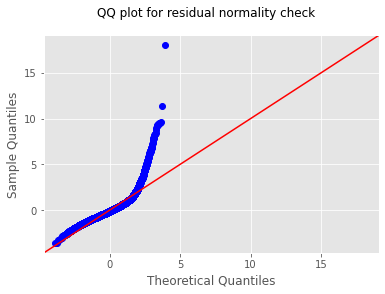

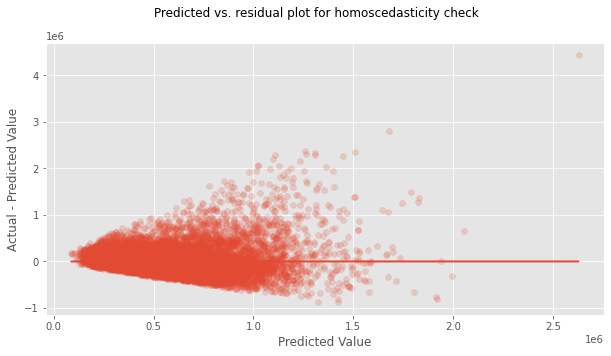

In [12]:
baseline = 'sqft_living'

y = data['price']
X = data[baseline]
reg_qq_sced(y, X)

#### Observations on Model 1:

* **The price of the house is prediced to inceease by $262.86 for each square foot added.**
* **An R-squared of .466 is low.**
    * This is the proportion of the variance of `price` that is explained by `sqft_living`.
    * This indicates that the model's fit is not great.
* **The conditions of normality (of residuals) and homoscedasticity are clearly violated.**

**As I observed before, `sqft_living` and `price` may have a better linear relationshop if they were log-transformed. I will do that now.** 

#### Log-transformation of continuous variables

In [13]:
# Isolate columns to be transformed
to_log = ['price', 'sqft_living']
data_logged = data.copy()[to_log]

# Log transforming and renaming columns
data_logged = np.log(data_logged)
data_logged.columns = data_logged.columns.map(lambda x: 'log_' + x)

# Merge it with the rest of the dataset
data_transformed = data_logged.join(data.drop(to_log, axis=1))

In [14]:
data_transformed.head(3)

,log_price,log_sqft_living,waterfront,view,renovated_last_10,floors_1.5,floors_2.0,floors_2.5,floors_3.0,bedrooms_2,...,condition_3_Average,condition_4_Good,condition_5_Very_Good,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,grade_10_Very_Good,grade_11_Excellent,grade_12_Luxury
0,12.309982,7.073270,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,13.195614,7.851661,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,12.100712,6.646391,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


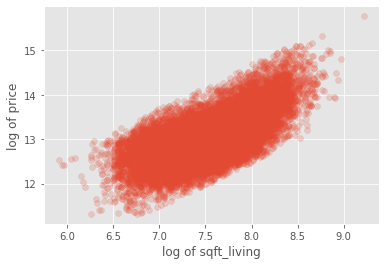

In [15]:
plt.scatter(
    x=data_transformed['log_sqft_living'],
    y=data_transformed['log_price'],
    alpha=.2
)
plt.xlabel('log of sqft_living')
plt.ylabel('log of price');

The relationship looks to be slightly improved.

### Model 1a

#### Same as Model 1, but with log-transformed features and predictors.
**Predictors:**
* `sqft_living`

C:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 1.688e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:11:17   Log-Likelihood:                -9972.4
No. Observations:               21378   AIC:                         1.995e+04
Df Residuals:                   21376   BIC:                         1.996e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8236      0.048    142.328      0.000       6.730       6.918
log_sqft_living     0.8241      0.006    129.925      0.000       0.812       0.837
==============================================================================
Omnibus:                      118.666   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.556
Skew:                           0.130   Prob(JB):                     7.27e-24
Kurtosis:                       2.772   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model adjusted R-squared: 0.44121910929171504
Model RMSE: 0.38580857869279717


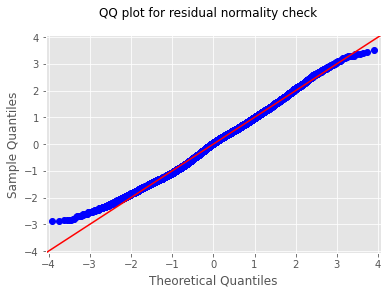

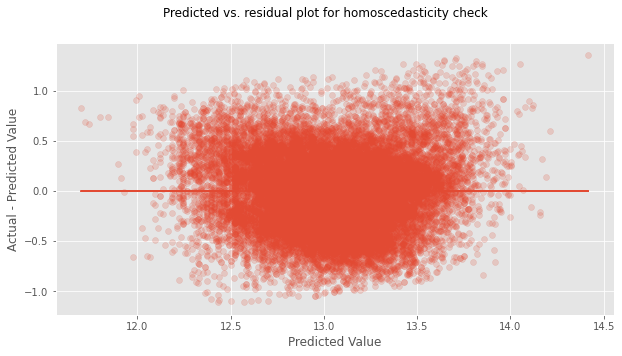

In [16]:
baseline = 'log_sqft_living'

y = data_transformed['log_price']
X = data_transformed[baseline]
reg_qq_sced(y, X)

#### Observations on Model 1a:

* **That improved the normality and homoscedasticity assumptions (relatively), but the R-squared is even lower.**

* **For my next model, I will try adding my binary variables (waterfront, view, and renovated_last_10).**

**Before I proceed, I will standardize `sqft_living` and `price` so that the coefficients are more comprable.**

#### Standardizing continuous variables

In [17]:
# Standardaizes data to mean and standard deviation.

def standardize(data):
    num = (data - np.mean(data))
    denom = np.std(data)
    return num/denom

In [18]:
to_standardize = ['log_price', 'log_sqft_living']
data_standardized = data_transformed.copy()[to_standardize]

data_standardized = standardize(data_standardized)
data_standardized.columns = data_standardized.columns.map(lambda x: 'stand_' + x)

# Merge it with the rest of the dataset
data_transformed = data_standardized.join(data_transformed.drop(to_standardize, axis=1))

# Preivew the dataset
data_transformed.head(3)

,stand_log_price,stand_log_sqft_living,waterfront,view,renovated_last_10,floors_1.5,floors_2.0,floors_2.5,floors_3.0,bedrooms_2,...,condition_3_Average,condition_4_Good,condition_5_Very_Good,grade_6_Low_Average,grade_7_Average,grade_8_Good,grade_9_Better,grade_10_Very_Good,grade_11_Excellent,grade_12_Luxury
0,-1.420605,-1.138992,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0.295375,0.732105,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,-1.826082,-2.165123,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


In [19]:
# saving this version of the dataset

# data_transformed.to_csv('./data/data_transformed.csv')

### Model 2
#### Baseline plus binary variables
**Predictors:**
* `sqft_living`
* binary variables
    * `waterfront`
    * `view`
    * `renovated_last_10`

C:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        stand_log_price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     4933.
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:11:18   Log-Likelihood:                -23344.
No. Observations:               21378   AIC:                         4.670e+04
Df Residuals:                   21373   BIC:                         4.674e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0642      0.005    -12.284      0.000      -0.075      -0.054
stand_log_sqft_living     0.6204      0.005    122.307      0.000       0.610       0.630
waterfront                0.9839      0.064     15.372      0.000       0.858       1.109
view                      0.5400      0.018     30.498      0.000       0.505       0.575
renovated_last_10         0.4679      0.043     10.759      0.000       0.383       0.553
==============================================================================
Omnibus:                      111.385   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.736
Skew:                           0.044   Prob(JB):                     1.08e-18
Kurtosis:                       2.708   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model adjusted R-squared: 0.47992149934586015
Model RMSE: 0.7211815510228193


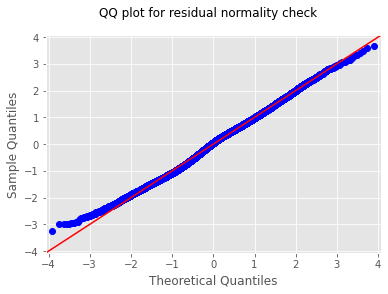

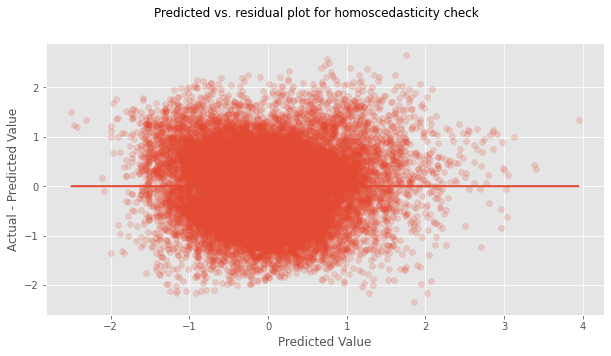

In [20]:
baseline = 'stand_log_sqft_living'

y = data_transformed['stand_log_price']
X = data_transformed[[baseline] + binary_cols]
reg_qq_sced(y, X)

#### Observations on Model 2:
* **The R-squared has been raised ever so slightly, but it's still low.**
* **The residual plot is still just  a big cloud, although I can at least argue that there is not a lot of variance along the line.**

### Model 3
#### Baseline plus categorical variables
**Predictors:**
* `sqft_living`
* categorical variables
    * `floors`
    * `bedrooms`
    * `bathrooms`
    * `condition`
    * `grade`

C:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        stand_log_price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     878.4
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:11:19   Log-Likelihood:                -20979.
No. Observations:               21378   AIC:                         4.203e+04
Df Residuals:                   21343   BIC:                         4.231e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.7780      0.110     -7.045      0.000      -0.995      -0.562
stand_log_sqft_living     0.4088      0.009     44.533      0.000       0.391       0.427
floors_1.5                0.3355      0.016     20.419      0.000       0.303       0.368
floors_2.0               -0.0525      0.013     -4.061      0.000      -0.078      -0.027
floors_2.5                0.2665      0.054      4.955      0.000       0.161       0.372
floors_3.0                0.2235      0.029      7.663      0.000       0.166       0.281
bedrooms_2               -0.1018      0.052     -1.971      0.049      -0.203      -0.001
bedrooms_3               -0.4219      0.052     -8.145      0.000      -0.523      -0.320
bedrooms_4               -0.4669      0.053     -8.798      0.000      -0.571      -0.363
bedrooms_5               -0.4622      0.056     -8.295      0.000      -0.571      -0.353
bedrooms_6               -0.4722      0.068     -6.981      0.000      -0.605      -0.340
bathrooms_1.0            -0.0462      0.089     -0.521      0.602      -0.220       0.127
bathrooms_1.5            -0.1431      0.090     -1.584      0.113      -0.320       0.034
bathrooms_1.75           -0.0763      0.090     -0.850      0.395      -0.252       0.100
bathrooms_2.0            -0.0906      0.090     -1.004      0.315      -0.267       0.086
bathrooms_2.25           -0.1181      0.091     -1.302      0.193      -0.296       0.060
bathrooms_2.5            -0.2196      0.090     -2.427      0.015      -0.397      -0.042
bathrooms_2.75           -0.0784      0.092     -0.853      0.394      -0.259       0.102
bathrooms_3.0            -0.0326      0.093     -0.350      0.727      -0.215       0.150
bathrooms_3.25            0.1037      0.095      1.095      0.273      -0.082       0.289
bathrooms_3.5             0.0293      0.094      0.311      0.756      -0.155       0.214
bathrooms_3.75            0.2551      0.106      2.415      0.016       0.048       0.462
bathrooms_4.0             0.1775      0.109      1.635      0.102      -0.035       0.390
bathrooms_4.25            0.2683      0.119      2.256      0.024       0.035       0.501
bathrooms_4.5             0.1436      0.114      1.256      0.209      -0.081       0.368
condition_3_Average       0.2154      0.051      4.233      0.000       0.116       0.315
condition_4_Good          0.3561      0.051      6.957      0.000       0.256       0.456
condition_5_Very_Good     0.6010      0.053     11.368      0.000       0.497       0.705
grade_6_Low_Average       0.3058      0.045      6.737      0.000       0.217       0.395
grade_7_Average           0.7023      0.045     15.617      0.000       0.614       0.790
grade_8_Good              1.1126      0.047     23.873      0.000       1.021       1.204
grade_9_Better         

Model adjusted R-squared: 0.5825424094184519
Model RMSE: 0.6461246930229574


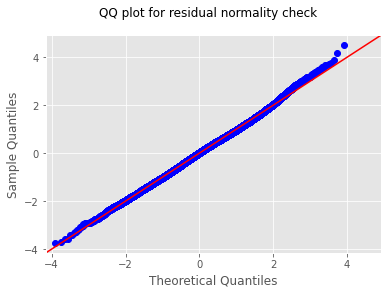

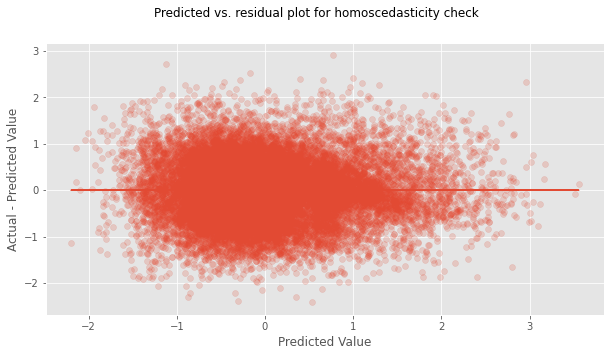

In [21]:
y = data_transformed['stand_log_price']
X = data_transformed[[baseline] + 
                     floors_dummies + 
                     bedrooms_dummies + 
                     bathrooms_dummies + 
                     condition_dummies + 
                     grade_dummies]
reg_qq_sced(y, X)

#### Observations on Model 3:
* **The R-squared is much better now.**
* **Homoscedasticity is violated more than before, but it's not terrible.**
* **There are quite a view dummy variable coefficients with high p-values, particularly with bathrooms and bedrooms.**
* **In some cases, bedrooms and bathrooms have negative coefficients for some reason. It doesn't make sense that these would decrease the price of the house., especially since the dummies that got dropped were *1 bedroom* and *.75 bathrooms.***
    * I'll drop bedrooms and bathrooms from the next model, and add back in the binary variables from Model 2.

### Model 4 (final)
**Predictors:**
* `sqft_living`
* binary variables
    * `view`
    * `waterfront` 
    * `renovated_last_10` 
* *some* categorical variables
    * `floors`
    * `condition` 
    * `grade`

C:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        stand_log_price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     1709.
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:11:19   Log-Likelihood:                -20800.
No. Observations:               21378   AIC:                         4.164e+04
Df Residuals:                   21359   BIC:                         4.179e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.2247      0.064    -19.020      0.000      -1.351      -1.098
stand_log_sqft_living     0.3081      0.007     45.510      0.000       0.295       0.321
waterfront                0.9009      0.057     15.815      0.000       0.789       1.013
view                      0.4006      0.016     25.051      0.000       0.369       0.432
renovated_last_10         0.5133      0.039     13.224      0.000       0.437       0.589
floors_1.5                0.3190      0.016     19.801      0.000       0.287       0.351
floors_2.0               -0.0509      0.012     -4.392      0.000      -0.074      -0.028
floors_2.5                0.2986      0.053      5.625      0.000       0.195       0.403
floors_3.0                0.2259      0.028      8.083      0.000       0.171       0.281
condition_3_Average       0.1944      0.050      3.855      0.000       0.096       0.293
condition_4_Good          0.3286      0.051      6.481      0.000       0.229       0.428
condition_5_Very_Good     0.5713      0.052     10.908      0.000       0.469       0.674
grade_6_Low_Average       0.2826      0.045      6.342      0.000       0.195       0.370
grade_7_Average           0.6175      0.044     14.145      0.000       0.532       0.703
grade_8_Good              1.0093      0.045     22.306      0.000       0.921       1.098
grade_9_Better            1.4873      0.048     31.053      0.000       1.393       1.581
grade_10_Very_Good        1.9053      0.051     37.124      0.000       1.805       2.006
grade_11_Excellent        2.2996      0.060     38.524      0.000       2.183       2.417
grade_12_Luxury           2.7144      0.093     29.249      0.000       2.532       2.896
==============================================================================
Omnibus:                        4.847   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.859
Skew:                           0.032   Prob(JB):                       0.0881
Kurtosis:                       2.965   Cond. No.                         43.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model adjusted R-squared: 0.589805011322074
Model RMSE: 0.6404796462740466


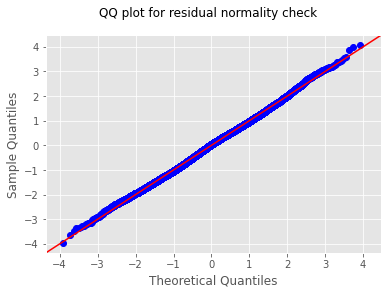

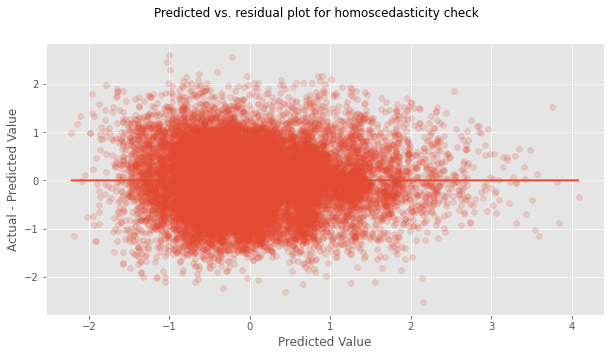

In [22]:
y = data_transformed['stand_log_price']
X = data_transformed[[baseline] + 
                     binary_cols + 
                     floors_dummies + 
                     condition_dummies + 
                     grade_dummies]
reg_qq_sced(y, X)

#### Observations on Model 4:
* **This is the best R-squared score so far.**
* **The coefficients make more sense this time.**

## Conclusions
### Final model
**The final model yields information allows us to make useful inferences about the predicted sale price of a house, as well what actions a homeowner may take in order to increase it.**

**Square footage of living space:** Increasing the square footage is associated with a higher sale price. Generally speaking, if a homeowner is able to increase this, the house can be expected to sell for more.

**Condition of the house (maintenance):** The reference point for the model is a house with a condition of "2_Fair." If the homehowner can do some maintenance to improve the condition of the house to any higher classification, the expected sale price should go up.

**Grade of the house (quality of construction):** The reference point for the model is a house with a grade of "5_Fair." Higher grades are associated with higher sale prices. If the homeowner can overhaul the quality of the construction and design of the house, that is expected to increase the sale price.

**Number of floors**: The fit of the model improved by taking this into account, but the coefficients are harder to interpret. The reference point is a house with 1 floor, so it seems illogical that going from 1 floor to 1.5 floors would increase the price, but going to 2 floors, would decrease it. It should be noted that a house with 1.5 floors is similar to one with 2 floors, and a house with 2.5 floors is similar to one with 3 floors. Generally speaking, adding floors to a house would increase sale price, but it's also unclear if that kind of renovation (which is probably very costly) would be worth the price increase.

**Waterfront and view**: Houses that are on a waterfront and houses with nice views will tend to sell for higher than houses that don't have these features. If either is true, then the real estate agency should emphasize these in the listing, photos, and any other marketing for the home sale.

**Renovated in the last 10 years**: Houses renovated in the past 10 years also tend to sell for higher. This aspect is probably also associated with condition and grade. Regardless, recent renovations should be emphasized in the listing and any marketing for the home sale.

## Limitations

A major limitation of the final model is that it doesn't predict the effect on home sale price in terms of dollars. The data has been transformed by taking the natural log of price and square footage. This was done in order to meet the assumptions of linear regression, but it makes the model less intuitive to interpret. As a result, we can tell whether a variable increases or decreases a home sale price, and we can tell the relative magnitude of the change, but figuring out the effect in terms of dollars requires some more advanced calculations. This can be limiting for someone who, say, wants to weigh whether a certain renovation will pay off when they sell their house. 

Another limitation is the final model's adjusted R-squared score. A score of 0.59 is not exemplary. We can still make meaningful inferences about how much price will change if a predictor is change, but we have to hedge these claims by saying that 41% of the variation in price is not explained by the predictors.